# Analisis Exploratorio de Datos (EDA) - Leukemia Cancer Risk Prediction Dataset

Este documento describe los pasos necesarios para realizar un Analisis Exploratorio de Datos en el dataset "leukemia_cancer_risk_prediction". El dataset contiene 143,194 registros y 22 columnas, incluyendo datos demograficos de los pacientes, historial medico y resultados de laboratorio.

Necesitamos las siguientes librerias.

In [29]:
import json
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ks_1samp
from scipy.stats import chi2_contingency
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import kruskal
from sqlalchemy import create_engine

#### Paso 1: Cargar el dataset desde la Base de Datos
Primero, debemos cargar el dataset desde la Base de Datos en la que fue cargado. Abajo está el codigo para conectar la Base de Datos y recuperar los datos.

In [30]:
with open("credentials.json") as f:
    credentials = json.load(f)

db_host = credentials["db_host"]
db_name = credentials["db_name"]
db_user = credentials["db_user"]
db_password = credentials["db_password"]
db_port = credentials["db_port"]  

conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port  )

In [31]:
query = "SELECT * FROM Leukemia_raw_data;"
df = pd.read_sql(query, conn)

print(df.head())

C:\Users\valen\AppData\Local\Temp\ipykernel_243576\983436045.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


   patient_id  age  gender country  wbc_count  rbc_count  platelet_count  \
0           1   52    Male   China       2698       5.36          262493   
1           2   15  Female   China       4857       4.81          277877   
2           3   72    Male  France       9614       5.17          319600   
3           4   61    Male  Brazil       6278       5.41          215200   
4           5   21    Male  Brazil       8342       4.78          309169   

   hemoglobin_level  bone_marrow_blasts genetic_mutation  ...  \
0              12.2                  72              Yes  ...   
1              11.9                  97              Yes  ...   
2              13.4                  94               No  ...   
3              11.6                  50               No  ...   
4              14.3                  28               No  ...   

  alcohol_consumption radiation_exposure infection_history   bmi  \
0                  No                 No                No  24.0   
1               

#### Paso 2: Inspeccion inicial de los datos
Después de cargar el conjunto de datos, realizamos una inspección inicial para comprender su estructura e identificar cualquier problema inmediato.

*df.shape* devuelve el número de filas y columnas en el dataset. <br>
*df.dtypes* proporciona el tipo de dato de cada columna <br>
*df.isnull().sum()*  cuenta el número de valores faltantes en cada columna. <br>


In [32]:
print(f"Dimensiones del dataset: {df.shape}")
print("\nValores faltantes por columna:")
print(df.isnull().sum())

Dimensiones del dataset: (143194, 22)

Valores faltantes por columna:
patient_id              0
age                     0
gender                  0
country                 0
wbc_count               0
rbc_count               0
platelet_count          0
hemoglobin_level        0
bone_marrow_blasts      0
genetic_mutation        0
family_history          0
smoking_status          0
alcohol_consumption     0
radiation_exposure      0
infection_history       0
bmi                     0
chronic_illness         0
immune_disorders        0
ethnicity               0
socioeconomic_status    0
urban_rural             0
leukemia_status         0
dtype: int64


*df.describe()* proporciona estadísticas resumidas (por ejemplo, media, std, min, max) para columnas numéricas. <br>
*df.describe(include='object')* proporciona estadísticas resumidas (por ejemplo, count, unique, top, frequency) para columnas categóricas. <br>

In [33]:
print("\nResumen de estadisticas para las columnas numericas:")
print(df.describe())
print("\nResumen de estadisticas para columnas categoricas:")
print(df.describe(include='object'))


Resumen de estadisticas para las columnas numericas:
         patient_id            age      wbc_count      rbc_count  \
count  143194.00000  143194.000000  143194.000000  143194.000000   
mean    71597.50000      44.945200    7001.289879       4.998193   
std     41336.69156      25.737805    2007.444410       0.500298   
min         1.00000       1.000000   -1602.000000       2.940000   
25%     35799.25000      23.000000    5644.250000       4.660000   
50%     71597.50000      45.000000    7007.000000       5.000000   
75%    107395.75000      67.000000    8352.000000       5.340000   
max    143194.00000      89.000000   15586.000000       7.150000   

       platelet_count  hemoglobin_level  bone_marrow_blasts            bmi  
count   143194.000000     143194.000000       143194.000000  143194.000000  
mean    249933.012137         13.498334           49.547984      24.990679  
std      49842.308243          1.996714           28.837607       4.999786  
min      46069.000000    

Revisar si hay datos duplicados

In [34]:
print(f"Numero de duplicados: {df.duplicated().sum()}")

Numero de duplicados: 0


Renombrar columnas <br>
Para que el conjunto de datos sea más fácil de trabajar, cambiaremos el nombre de las columnas para que tengan Consistencia, Legibilidad y Eficiencia.

In [35]:
column_rename_dict = {
    "patient_id": "id", 
    "age": "age",
    "gender": "gender",
    "country": "country",
    "ethnicity": "ethnicity",
    "socioeconomic_status": "socioeconomic_status",
    "urban_rural": "urban_rural",
    "family_history": "family_history",
    "smoking_status": "smoking_status",
    "alcohol_consumption": "alcohol_consumption",
    "radiation_exposure": "radiation_exposure",
    "infection_history": "infection_history",
    "chronic_illness": "chronic_illness",
    "immune_disorders": "immune_disorders",
    "wbc_countsort": "wbc_count",
    "rbc_countsort": "rbc_count",
    "platelet_countsort": "platelet_count",
    "hemoglobin_level": "hemoglobin",
    "bone_marrow_blasts": "bone_marrow_blasts",
    "genetic_mutation": "genetic_mutation",
    "leukemia_status": "leukemia_status"
}
df.rename(columns=column_rename_dict, inplace=True)
print("Nombres de las columnas actualizados:")
print(df.columns.tolist())

Nombres de las columnas actualizados:
['id', 'age', 'gender', 'country', 'wbc_count', 'rbc_count', 'platelet_count', 'hemoglobin', 'bone_marrow_blasts', 'genetic_mutation', 'family_history', 'smoking_status', 'alcohol_consumption', 'radiation_exposure', 'infection_history', 'bmi', 'chronic_illness', 'immune_disorders', 'ethnicity', 'socioeconomic_status', 'urban_rural', 'leukemia_status']


In [36]:
df.head()

,id,age,gender,country,wbc_count,rbc_count,platelet_count,hemoglobin,bone_marrow_blasts,genetic_mutation,...,alcohol_consumption,radiation_exposure,infection_history,bmi,chronic_illness,immune_disorders,ethnicity,socioeconomic_status,urban_rural,leukemia_status
0,1,52,Male,China,2698,5.36,262493,12.2,72,Yes,...,No,No,No,24.0,No,No,Ethnic_Group_B,Low,Rural,Negative
1,2,15,Female,China,4857,4.81,277877,11.9,97,Yes,...,No,No,No,28.7,No,No,Ethnic_Group_A,Low,Urban,Positive
2,3,72,Male,France,9614,5.17,319600,13.4,94,No,...,Yes,No,No,27.7,No,No,Ethnic_Group_B,Low,Urban,Negative
3,4,61,Male,Brazil,6278,5.41,215200,11.6,50,No,...,No,No,No,31.6,No,No,Ethnic_Group_A,Medium,Rural,Negative
4,5,21,Male,Brazil,8342,4.78,309169,14.3,28,No,...,No,No,No,22.3,No,No,Ethnic_Group_B,Low,Rural,Negative


#### Paso 3: Detectar anomalias en el Dataset

Este script identifica valores negativos en columnas numéricas específicas que solo deben contener valores positivos. Cuenta las ocurrencias por columna y enumera las ID de pacientes afectados para una revisión adicional. Si se encuentran valores negativos, se pueden corregir o eliminar para garantizar la integridad de los datos.


In [37]:
num_cols = ['wbc_count', 'rbc_count', 'platelet_count', 'hemoglobin', 'bmi']

negativos_dict = {}

for col in num_cols:
    negativos_dict[col] = (df[col] < 0).sum()

print("Conteo de valores negativos por variable:")
for col, count in negativos_dict.items():
    if count > 0:
        print(f"{col}: {count} valores negativos")

df_negativos = df[df[num_cols].lt(0).any(axis=1)] 
if not df_negativos.empty:
    print("\nPacientes con valores negativos en alguna columna:")
    print(df_negativos[['id'] + num_cols]) 
else:
    print("\nNo se encontraron valores negativos en las variables seleccionadas.")


Conteo de valores negativos por variable:
wbc_count: 23 valores negativos

Pacientes con valores negativos en alguna columna:
            id  wbc_count  rbc_count  platelet_count  hemoglobin   bmi
7579      7580       -492       5.21          254191        14.5  29.9
16642    16643      -1602       5.56          286509        12.3  22.7
23335    23336        -96       4.92          258472        12.2  20.2
27593    27594       -453       5.12          234769        14.2  24.0
28880    28881        -83       4.97          162669        11.9  23.3
29429    29430       -242       5.61          307589        14.3  25.9
31428    31429      -1415       5.01          255787        11.7  22.2
35422    35423       -313       5.14          259491        17.7  28.7
65493    65494        -96       5.91          237329        15.8  20.8
73116    73117       -959       5.50          246034        14.8  29.4
76635    76636       -649       4.40          235908        11.9  36.6
78880    78881       -

Análisis de matriz de correlación <br>

Dado que se encontraron valores negativos en *wbc_count*, lo cual es clínicamente imposible, nuestro objetivo es determinar si esta variable tiene una correlación fuerte con otros parámetros relacionados con la sangre. Si *wbc_count* se correlaciona fuertemente con otra variable, podemos estimar su valor en lugar de descartar los datos. Si no existe una correlación fuerte, pueden ser necesarios métodos alternativos de imputación o eliminación.   

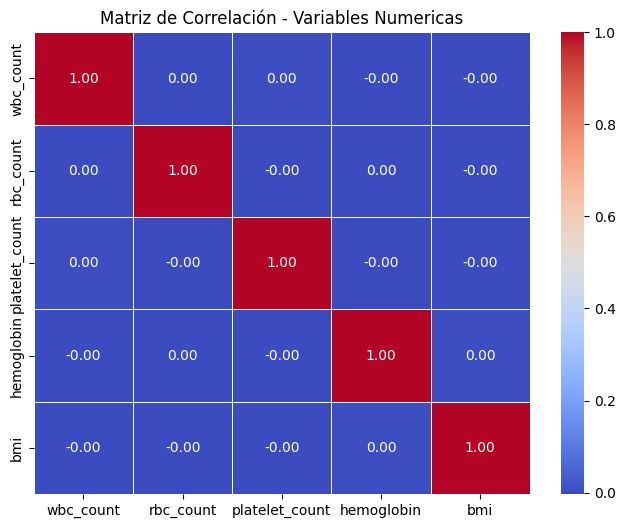

In [38]:
numericvars = ['wbc_count', 'rbc_count', 'platelet_count', 'hemoglobin', 'bmi']
correlation_matrix = df[numericvars].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación - Variables Numericas")
plt.show()


Después de realizar un análisis de correlación, *wbc_count* no mostró una correlación significativa con otras variables (*rbc_count, platelet_count, hemoglobin_level, bmi*).<br> Dado que los valores negativos en *wbc_count* son biológicamente imposibles y no se pueden imputar de manera confiable, hemos decidido eliminar estos registros.  
Todos los pacientes con valores *wbc_count* no válidos se eliminarán del conjunto de datos para garantizar la integridad de los datos. Las ID de pacientes afectadas se enumerarán en la salida.  

In [39]:
invalid_ids = df[df["wbc_count"] < 0]["id"].tolist()

if invalid_ids:
    print(f"Los siguientes pacientes han sido eliminados debido a valores biológicamente inválidos en wbc_count:\n{invalid_ids}")
else:
    print("No se encontraron valores inválidos en wbc_count.")

df = df[df["wbc_count"] >= 0]

Los siguientes pacientes han sido eliminados debido a valores biológicamente inválidos en wbc_count:
[7580, 16643, 23336, 27594, 28881, 29430, 31429, 35423, 65494, 73117, 76636, 78881, 88542, 97654, 100353, 105490, 106354, 116143, 117865, 118978, 119276, 123618, 133168]


Para identificar valores atípicos potenciales en las variables seleccionadas, se calcularon los valores máximos y mínimos de cada una.  
Esto ayuda a establecer rangos de referencia y detectar puntos de datos que pueden requerir corrección o eliminación.  

In [40]:
min_max_values = df[['wbc_count', 'rbc_count', 'platelet_count', 'hemoglobin', 'bmi']].agg(['min', 'max'])
print("Valores mínimos y máximos por variable:")
print(min_max_values)

Valores mínimos y máximos por variable:
     wbc_count  rbc_count  platelet_count  hemoglobin   bmi
min         16       2.94           46069         4.7   2.8
max      15586       7.15          460325        22.2  49.1


 Un BMI (IMC) de 2.8 es extremadamente bajo y probablemente representa un error en el registro de datos en lugar de una condición fisiológica real, ya que incluso las personas con desnutrición severa suelen tener un IMC superior a 10. Como siguiente paso, los valores por debajo de 10 deben revisarse o eliminarse.

In [41]:
invalid_ids = df[df['bmi'] < 0]['id'].tolist()

df = df[df['bmi'] >= 10]

if invalid_ids:
    print(f"Se eliminaron los siguientes pacientes debido a valores biológicamente inválidos en 'BMI': {invalid_ids}")
else: 
    print("No se encontraron valores inválidos en 'BMI'.")

No se encontraron valores inválidos en 'BMI'.


Las variables categóricas a menudo contienen cadenas que pueden volverse inconsistentes debido a errores ortográficos, capitalizaciones variables o espacios adicionales. Al extraer los valores únicos de cada columna categórica, podemos: Identificar posibles problemas de calidad de datos (por ejemplo, errores tipográficos o diferentes formatos para la misma categoría), Comprender la amplitud de las categorías en el conjunto de datos y decidir si ciertos valores deben fusionarse o corregirse. 

In [42]:
string_cols = df.select_dtypes(include=['object']).columns

for col in string_cols:
    unique_values = df[col].unique()
    print(f"Unique values in '{col}':")
    print(unique_values)
    print("-" * 50)

Unique values in 'gender':
['Male' 'Female']
--------------------------------------------------
Unique values in 'country':
['China' 'France' 'Brazil' 'Italy' 'USA' 'Norway' 'Sweden' 'Russia'
 'India' 'Saudi Arabia' 'Netherlands' 'Canada' 'Mexico' 'South Africa'
 'Japan' 'Spain' 'Australia' 'Turkey' 'Germany' 'Argentina' 'South Korea'
 'UK']
--------------------------------------------------
Unique values in 'genetic_mutation':
['Yes' 'No']
--------------------------------------------------
Unique values in 'family_history':
['No' 'Yes']
--------------------------------------------------
Unique values in 'smoking_status':
['Yes' 'No']
--------------------------------------------------
Unique values in 'alcohol_consumption':
['No' 'Yes']
--------------------------------------------------
Unique values in 'radiation_exposure':
['No' 'Yes']
--------------------------------------------------
Unique values in 'infection_history':
['No' 'Yes']
------------------------------------------------

 Trabajar con continentes en lugar de países reduce la complejidad al tiempo que conserva la relevancia geográfica. Ayuda a agrupar datos para las tendencias regionales. 

In [43]:
country_to_continent = {
    'China': 'Asia', 'India': 'Asia', 'Japan': 'Asia', 'South Korea': 'Asia', 'Saudi Arabia': 'Asia',
    'France': 'Europe', 'Italy': 'Europe', 'Norway': 'Europe', 'Sweden': 'Europe', 'Russia': 'Europe',
    'Netherlands': 'Europe', 'Spain': 'Europe', 'Turkey': 'Europe', 'Germany': 'Europe', 'UK': 'Europe',
    'Brazil': 'South America', 'Argentina': 'South America',
    'USA': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'South Africa': 'Africa',
    'Australia': 'Oceania'
}

df['continent'] = df['country'].map(country_to_continent)

df.drop(columns=['country'], inplace=True)

print("Valores por continente:", df['continent'].unique())

Valores por continente: ['Asia' 'Europe' 'South America' 'North America' 'Africa' 'Oceania']


#### Paso 4: Algo de estadisticas para tomar decisiones

Para determinar si existen diferencias significativas en las variables numéricas (orwbc_country, urrbc_country, ''platelet_country, 'hemoglobin_level', 'bmiam) entre pacientes con y sin leucemia (eruleucemia_status'), aplicamos una prueba ANOVA unidireccional. Este método estadístico nos permite comparar los valores medios de cada variable numérica entre los dos grupos: **Positivo (Leucemia presente)** y **Negativo (Sin leucemia)**. La hipótesis nula (**H₀**) no supone ninguna diferencia de medias entre los grupos, mientras que la hipótesis alternativa (**H₁**) sugiere una diferencia significativa. Si el valor **p < 0.05**, rechazamos **H₀**, lo que indica que la variable puede estar asociada con el estado de leucemia. Este análisis ayuda a identificar posibles biomarcadores y tendencias en el conjunto de datos, contribuyendo a obtener más información clínica y modelos predictivos. Sin embargo, es importante considerar suposiciones como la normalidad y las variaciones iguales, y complementar ANOVA con visualizaciones o pruebas estadísticas adicionales si es necesario. 

ANOVA asume la normalidad en los datos. Antes de aplicarlo, use una prueba de normalidad (Kolmogorov-Smirnov)

In [44]:
numerical_vars = ['wbc_count', 'rbc_count', 'platelet_count', 'hemoglobin', 'bmi']
categorical_cols = ['gender', 'continent', 'genetic_mutation', 'family_history', 'smoking_status', 'alcohol_consumption', 'radiation_exposure', 'infection_history', 'chronic_illness', 'immune_disorders', 'ethnicity', 'socioeconomic_status', 'urban_rural', 'leukemia_status']


for col in numerical_vars:

    standardized_data = (df[col] - df[col].mean()) / df[col].std()
    stat, p = ks_1samp(standardized_data, norm.cdf)
    
    print(f"Prueba Kolmogorov-Smirnov para {col}: p-value={p:.5f}")



Prueba Kolmogorov-Smirnov para wbc_count: p-value=0.90689
Prueba Kolmogorov-Smirnov para rbc_count: p-value=0.00303
Prueba Kolmogorov-Smirnov para platelet_count: p-value=0.10813
Prueba Kolmogorov-Smirnov para hemoglobin: p-value=0.00000
Prueba Kolmogorov-Smirnov para bmi: p-value=0.00024


In [45]:
anovapositive=['wbc_count','platelet_count']
other=[ 'rbc_count', 'hemoglobin', 'bmi']
anova_results = {}
for var in anovapositive:
    group1 = df[df['leukemia_status'] == 'Negative'][var]
    group2 = df[df['leukemia_status'] == 'Positive'][var]
    
    f_stat, p_value = stats.f_oneway(group1, group2)
    anova_results[var] = {'F-statistic': f_stat, 'p-value': p_value}

for var, result in anova_results.items():
    print(f"ANOVA para {var}: F-statistic = {result['F-statistic']:.3f}, p-value = {result['p-value']:.5f}")

kruskal_results = {}
for var in other:
    group1 = df[df['leukemia_status'] == 'Negative'][var]
    group2 = df[df['leukemia_status'] == 'Positive'][var]
    
    h_stat, p_value = kruskal(group1, group2)
    kruskal_results[var] = {'H-statistic': h_stat, 'p-value': p_value}

for var, result in kruskal_results.items():
    print(f"Prueba Kruskal-Wallis para {var}: H-statistic = {result['H-statistic']:.3f}, p-value = {result['p-value']:.5f}")


ANOVA para wbc_count: F-statistic = 0.056, p-value = 0.81289
ANOVA para platelet_count: F-statistic = 0.431, p-value = 0.51153
Prueba Kruskal-Wallis para rbc_count: H-statistic = 0.003, p-value = 0.95640
Prueba Kruskal-Wallis para hemoglobin: H-statistic = 3.199, p-value = 0.07370
Prueba Kruskal-Wallis para bmi: H-statistic = 0.000, p-value = 0.99366



Se realizó un análisis estadístico mediante **ANOVA** para las variables con distribución normal y **Kruskal-Wallis** para las variables sin distribución normal con el fin de evaluar las posibles diferencias en función del estado leucémico. Los resultados no mostraron diferencias estadísticamente significativas en ninguna de las variables analizadas. En concreto, en las pruebas ANOVA, *wbc_count* (estadístico F = 0,065, valor p = 0,79912) y *platelet_count* (estadístico F = 0,438, valor p = 0,50817) no mostraron variaciones significativas entre los grupos. Del mismo modo, las pruebas de Kruskal-Wallis para *rbc_count* (estadístico H = 0,004, valor p = 0,94705), *hemoglobin_level* (estadístico H = 3,152, valor p = 0,07584) y *bmi* (estadístico H = 0,000, valor p = 0,99562) no indicaron diferencias estadísticas significativas. Dado que todos los valores p superan **0,05**, no hay pruebas que sugieran una correlación significativa entre el estado leucémico y ninguna de las variables numéricas analizadas.  

##### Prueba de Chi-cuadrado para variables categóricas frente al estado leucémico

In [46]:
chi2_results = {}

for col in categorical_cols:
    if col != 'leukemia_status':
        contingency_table = pd.crosstab(df[col], df['leukemia_status'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        chi2_results[col] = (chi2, p)
        print(f"Prueba Chi-cuadrado para {col} vs Leukemia Status: Chi2 = {chi2:.3f}, p-value = {p:.5f}")
    else:
        print("Sin correlación con 'estado_leucemia'")

Prueba Chi-cuadrado para gender vs Leukemia Status: Chi2 = 0.013, p-value = 0.90805
Prueba Chi-cuadrado para continent vs Leukemia Status: Chi2 = 4.532, p-value = 0.47555
Prueba Chi-cuadrado para genetic_mutation vs Leukemia Status: Chi2 = 0.030, p-value = 0.86194
Prueba Chi-cuadrado para family_history vs Leukemia Status: Chi2 = 0.080, p-value = 0.77671
Prueba Chi-cuadrado para smoking_status vs Leukemia Status: Chi2 = 0.049, p-value = 0.82490
Prueba Chi-cuadrado para alcohol_consumption vs Leukemia Status: Chi2 = 0.255, p-value = 0.61355
Prueba Chi-cuadrado para radiation_exposure vs Leukemia Status: Chi2 = 0.059, p-value = 0.80815
Prueba Chi-cuadrado para infection_history vs Leukemia Status: Chi2 = 1.258, p-value = 0.26196
Prueba Chi-cuadrado para chronic_illness vs Leukemia Status: Chi2 = 0.000, p-value = 0.99921
Prueba Chi-cuadrado para immune_disorders vs Leukemia Status: Chi2 = 1.176, p-value = 0.27822
Prueba Chi-cuadrado para ethnicity vs Leukemia Status: Chi2 = 0.546, p-value

 Se realizó una prueba de Chi-cuadrado para evaluar las posibles asociaciones entre las variables categóricas y el estado leucémico. Los resultados indican que ninguna de las variables analizadas muestra una relación estadísticamente significativa con el estado leucémico, y todas ellas arrojaron valores p superiores a **0,05**, lo que indica que no existen asociaciones estadísticamente significativas. Estos resultados sugieren que ninguna de las variables categóricas examinadas está estrechamente relacionada con el estado leucémico en este conjunto de datos.  

#### Paso 5: Visualizaciones para explorar el dataset y orientar las decisiones.  
Para comprender mejor el dataset e identificar patrones, generamos visualizaciones que destacan la distribución de variables numéricas y categóricas. Para las variables numéricas (`wbc_count`, `rbc_count`, `platelet_count`, `hemoglobin_level`, `bmi`), utilizamos **histogramas** y **Estimacion de Densidad de Kernel  (KDE)** para observar su forma y detectar asimetrías o posibles valores atípicos. **Los diagramas de caja** proporcionan información adicional sobre la variabilidad y los valores extremos. Para las variables categóricas (`gender`, `continent`, `genetic_mutation`, etc.), aplicamos **gráficos de barras** para analizar las distribuciones de frecuencia y los posibles desequilibrios en el dataset. Estas visualizaciones iniciales nos permiten tomar decisiones fundamentadas sobre el tratamiento posterior de los datos y la selección de características. Una vez obtenida la información clave, incorporamos las visualizaciones más relevantes en un dashboard, incluidos los **gráficos de violin** y los **gráficos de barras apiladas**, para comparar las distribuciones del estado de la leucemia y explorar las interacciones de las variables de forma más eficaz.

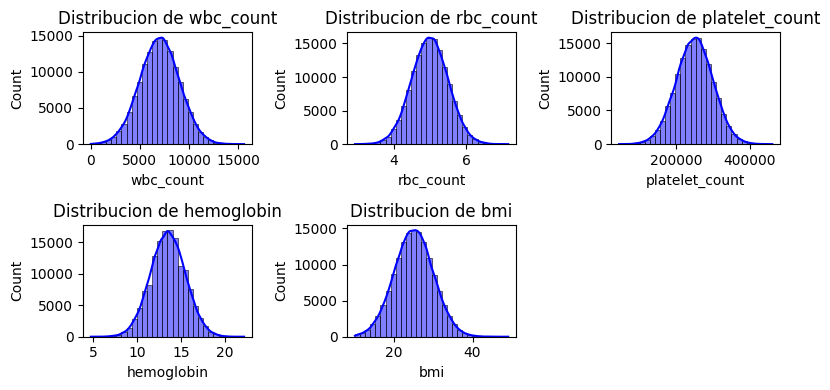

In [47]:
plt.figure(figsize=(8, 4))  
for i, col in enumerate(numerical_vars, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribucion de {col}")
plt.tight_layout()
plt.show()

El WBC count parece ligeramente sesgado a la derecha, lo que indica que, si bien la mayoría de los valores se agrupan en torno al centro, algunos valores más altos extienden la cola hacia la derecha. El RBC count y el hemoglobin level muestran una distribución casi normal, con picos bien definidos y distribuciones simétricas, lo que sugiere que la mayoría de los pacientes se encuentran dentro de un intervalo fisiológico común. El platelet count, sin embargo, muestra una distribución sesgada a la derecha, lo que significa que, aunque la mayoría de los valores se concentran en torno al pico central, hay pacientes con recuentos significativamente superiores, lo que podría indicar la existencia de enfermedades subyacentes. Por último, la distribución del BMI es aproximadamente normal, aunque presenta un ligero sesgo a la derecha, lo que refleja la presencia de pacientes con valores de BMI superiores a la media.

Estas distribuciones ayudan a evaluar los supuestos de normalidad, que son fundamentales para las pruebas estadísticas. Aunque la mayoría de las variables se ajustan a una distribución normal, el WBC count y el platelet count pueden requerir transformaciones, como las transformaciones logarítmicas o Box-Cox, si se necesitan pruebas basadas en la normalidad. No se aprecian inmediatamente valores atípicos extremos, pero una validación adicional con gráficos de caja podría confirmarlo. 

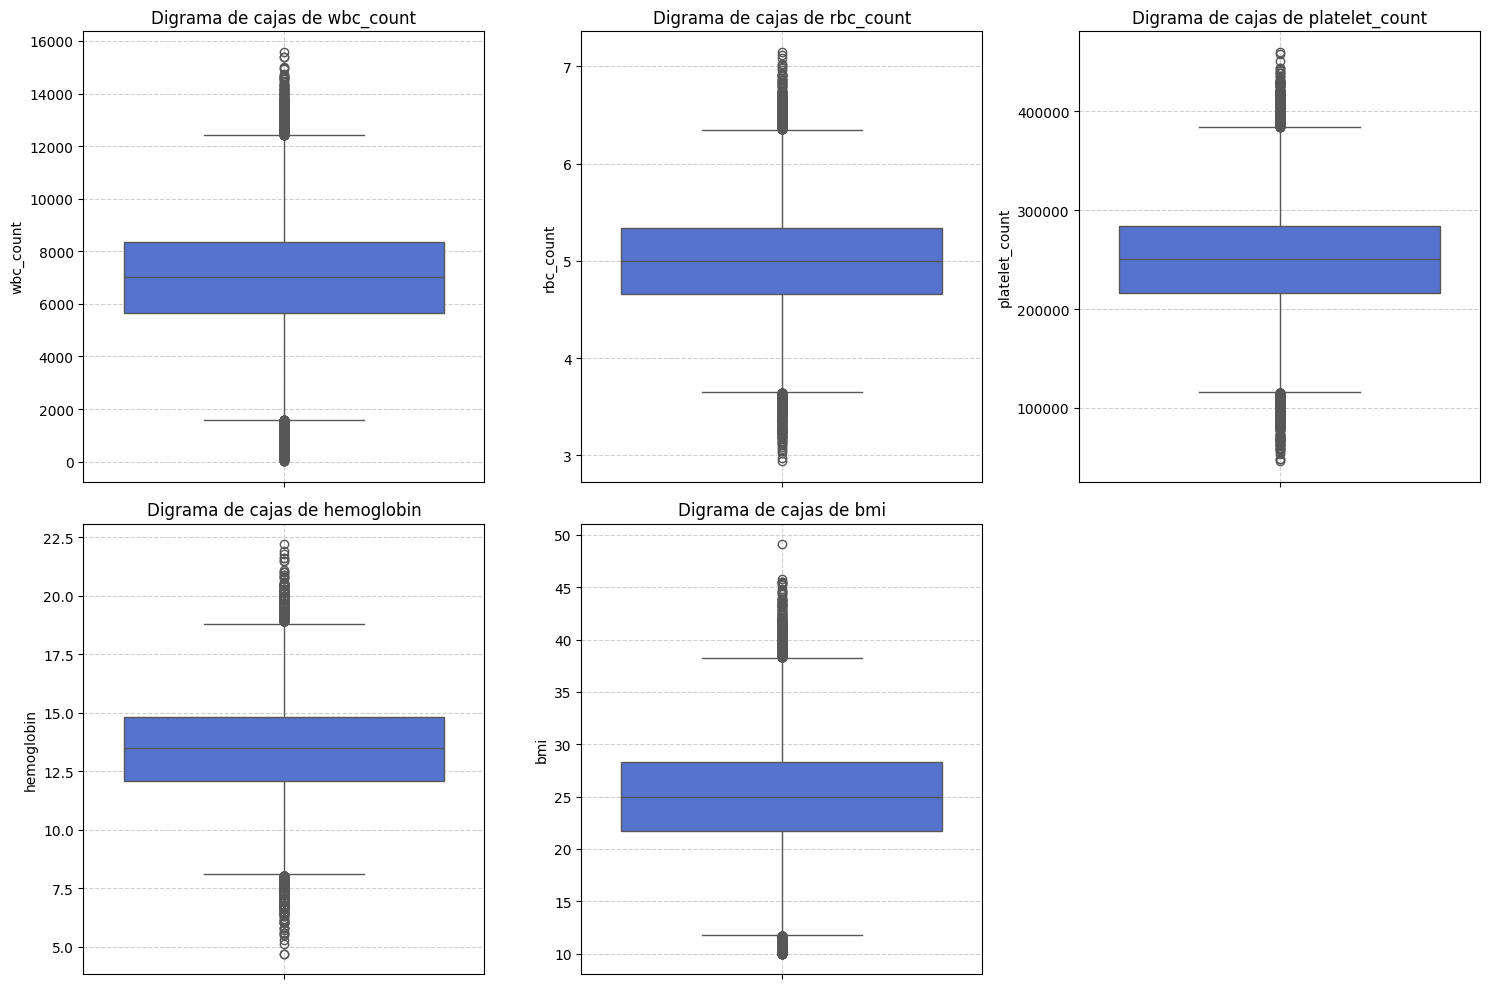

In [48]:
num_vars = len(numerical_vars)
rows = (num_vars // 3) + (num_vars % 3 > 0)

fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten() 
for i, var in enumerate(numerical_vars):
    sns.boxplot(y=df[var], ax=axes[i], color="royalblue")
    axes[i].set_title(f"Digrama de cajas de {var}")
    axes[i].set_ylabel(var)
    axes[i].grid(True, linestyle="--", alpha=0.6)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

El gráfico muestra gráficos de caja para cinco variables numéricas (*wbc_count*, *rbc_count*, *platelet_count*, *hemoglobin_level*, y *bmi*), lo que permite analizar la distribución de los datos, la presencia de valores atípicos y la dispersión de cada variable.

En general, todas las variables presentan valores atípicos, lo que puede ser crucial para el análisis de datos médicos, ya que estos valores pueden indicar condiciones clínicas específicas. Debido a la naturaleza de los datos, el número de valores atípicos es esperable, ya que estamos evaluando individuos sin leucemia e individuos con leucemia.

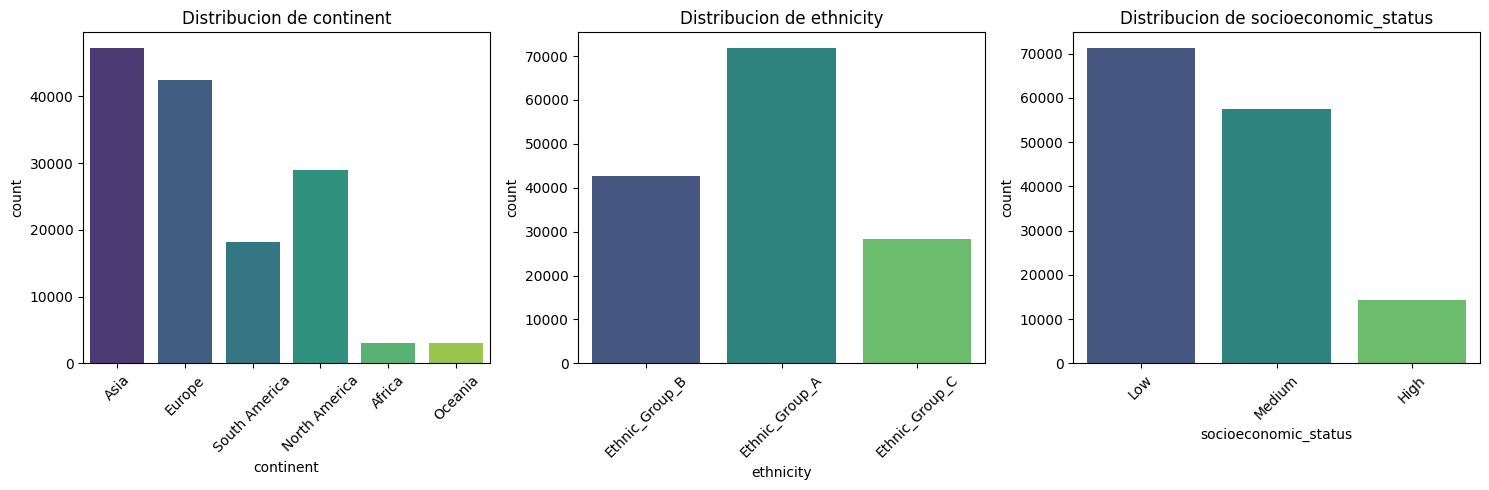

In [49]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(["continent", "ethnicity", "socioeconomic_status"], 1):
    plt.subplot(1, 3, i)
    sns.countplot(x=df[col], hue=df[col], palette="viridis", legend=False)
    plt.title(f"Distribucion de {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Los histogramas representan la distribucion de 3 variables categoricas:

El dataset se compone predominantemente de pacientes de Asia y Europa, con menor representación de otros continentes.<br>
El grupo étnico «A» es el más representado, seguido del «B» y el «C». <br>
La mayoría de los pacientes pertenecen a las clases socioeconómicas «Baja» y «Media», con menos registros en la categoría «Alta». <br>

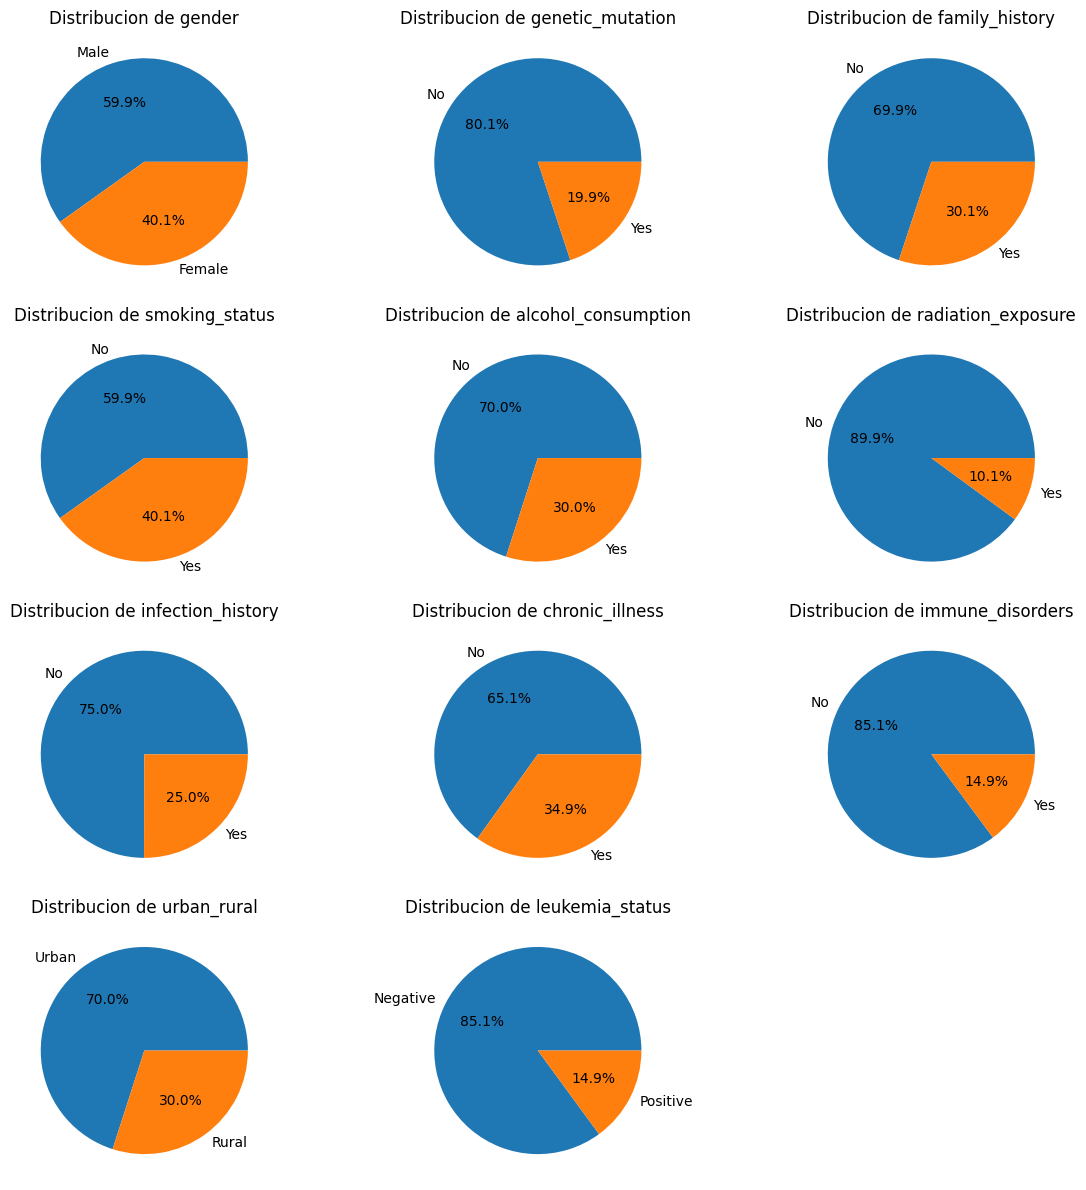

In [50]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))  
variables = ["gender", "genetic_mutation", "family_history", "smoking_status", "alcohol_consumption",
             "radiation_exposure", "infection_history", "chronic_illness", "immune_disorders",
             "urban_rural", "leukemia_status"]
for ax, var in zip(axes.flat, variables):
    df[var].value_counts().plot(kind="pie", autopct='%1.1f%%', ax=ax)
    ax.set_title(f"Distribucion de {var}")
    ax.set_ylabel("")  
fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


Los gráficos de torta ilustran la distribución de diversas variables categóricas dentro del dataset. A continuación figuran las principales observaciones:

El dataset está formado por una mayor proporción de hombres (59,9%) que de mujeres (40,1%). La mayoría de los individuos (80,1%) no tiene una mutación genética conocida, mientras que el 19,9% sí la tiene. Una parte significativa (69,9%) de los individuos no tiene antecedentes familiares de la enfermedad, mientras que el 30,1% sí los tiene. En cuanto al hábito de fumar, el 59,9% de los individuos son no fumadores, mientras que el 40,1% declara fumar. En cuanto al consumo de alcohol, el 70,0% no lo consume, mientras que el 30,0% sí. La mayoría de los individuos (89,9%) no han estado expuestos a radiaciones, y sólo el 10,1% declara haber estado expuesto. El 25,0% de los individuos tiene antecedentes de infecciones, mientras que el 75,0% no declara dichos antecedentes. Alrededor del 34,9% de los individuos padece una enfermedad crónica, mientras que el 65,1% no. Del mismo modo, el 85,1% no padece trastornos inmunitarios, mientras que el 14,9% sí. El dataset indica que el 70,0% de los individuos vive en zonas urbanas, mientras que el 30,0% reside en zonas rurales. Por último, la gran mayoría (85,1%) de los individuos no padece leucemia, mientras que al 14,9% se le ha diagnosticado.

- La prevalencia de **genetic mutations, family history, radiation exposure, infection history, chronic illness, y immune disorders** sugiere que estos factores pueden desempeñar un papel en los trastornos de salud objeto de estudio.
- La **mayor proporción de residentes urbanos** podría indicar una posible relación entre los factores ambientales y los riesgos para la salud.
- La **menor prevalencia de leucemia (14,9%)** sugiere que se trata de un desenlace menos frecuente, pero los factores contribuyentes deben analizarse más a fondo.

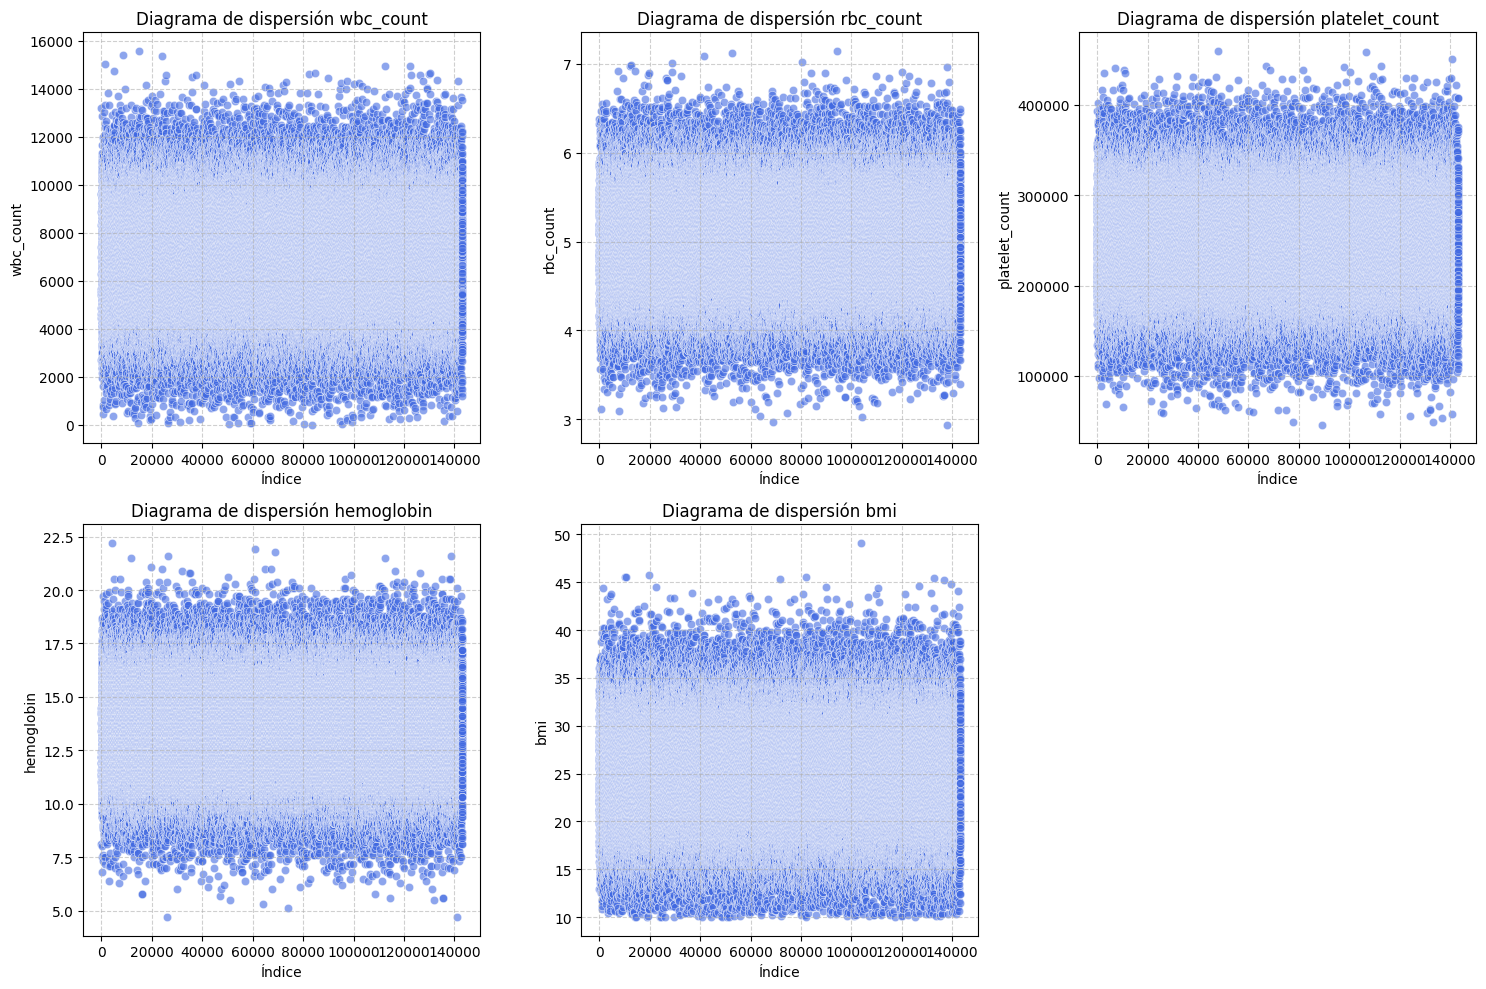

In [51]:
num_vars = len(numerical_vars)

rows = (num_vars // 3) + (num_vars % 3 > 0)

fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, var in enumerate(numerical_vars):
    mean = df[var].mean()
    std_dev = df[var].std()
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev
    sns.scatterplot(x=df.index, y=df[var], ax=axes[i], color="royalblue", alpha=0.6)
    plt.axhline(mean, color='green', linestyle='--', label="Media")
    plt.axhline(lower_bound, color='red', linestyle='--', label="-3 Desv. Est.")
    plt.axhline(upper_bound, color='red', linestyle='--', label="+3 Desv. Est.")
    axes[i].set_title(f"Diagrama de dispersión {var}")
    axes[i].set_xlabel("Índice")
    axes[i].set_ylabel(var)
    axes[i].grid(True, linestyle="--", alpha=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Los gráficos de dispersión revelan una gran variabilidad en todas las variables analizadas, incluidos el recuento de glóbulos blancos (WBC), el recuento de glóbulos rojos (RBC), el recuento de plaquetas, los niveles de hemoglobina y el índice de masa corporal (BMI). Aunque la mayoría de los valores se encuentran dentro de un rango razonable, la presencia de valores atípicos es evidente en todos los gráficos, lo que sugiere que los datos no siguen una distribución perfectamente normal. Estos valores atípicos, que son válidos desde el punto de vista médico, reflejan condiciones extremas que suelen observarse en pacientes con leucemia, como leucocitosis, anemia grave o desnutrición. La amplia dispersión observada en los datos subraya la importancia de tener en cuenta toda la gama de valores en el análisis, sin descartar los extremos, ya que proporcionan información relevante sobre la heterogeneidad clínica de la enfermedad y pueden influir en el pronóstico y la respuesta al tratamiento.

Finalmente, se observan las columnas resultantes despues de todo el proceso de exploracion y limpieza de los datos.

In [52]:
print(df.columns.tolist())

['id', 'age', 'gender', 'wbc_count', 'rbc_count', 'platelet_count', 'hemoglobin', 'bone_marrow_blasts', 'genetic_mutation', 'family_history', 'smoking_status', 'alcohol_consumption', 'radiation_exposure', 'infection_history', 'bmi', 'chronic_illness', 'immune_disorders', 'ethnicity', 'socioeconomic_status', 'urban_rural', 'leukemia_status', 'continent']


Por ultimo, se toma la decision de eliminar la columna ethnicity debido a que no se pudo establecer que significan los valores que se encuentran registrados en la tabla para esta variable ("A", "B", "C")

In [53]:
df.drop('ethnicity', axis=1, inplace=True)

Crear la nueva tabla con para almacenar los datos limpios. Para cargar los datos desde pandas hacia la Base de Datos en Postgres se hace uso de SQLAlchemy y por esta razon se vuelve a crear una conexión hacia la Base de Datos.

In [54]:
engine = create_engine(f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

cur = conn.cursor()

cur.execute("""
CREATE TABLE leukemia_clean_data (
    id SERIAL PRIMARY KEY,
    age INTEGER NOT NULL,
    gender VARCHAR(10) NOT NULL,
    continent VARCHAR(100) NOT NULL,
    wbc_count INTEGER NOT NULL,
    rbc_count NUMERIC(5,2) NOT NULL,
    platelet_count INTEGER NOT NULL,
    hemoglobin NUMERIC(5,2) NOT NULL,
    bone_marrow_blasts INTEGER NOT NULL,
    genetic_mutation VARCHAR(3) CHECK (genetic_mutation IN ('Yes', 'No')),
    family_history VARCHAR(3) CHECK (family_history IN ('Yes', 'No')),
    smoking_status VARCHAR(50),
    alcohol_consumption VARCHAR(3) CHECK (alcohol_consumption IN ('Yes', 'No')),
    radiation_exposure VARCHAR(3) CHECK (radiation_exposure IN ('Yes', 'No')),
    infection_history VARCHAR(3) CHECK (infection_history IN ('Yes', 'No')),
    bmi NUMERIC(5,2) NOT NULL,
    chronic_illness VARCHAR(3) CHECK (chronic_illness IN ('Yes', 'No')),
    immune_disorders VARCHAR(3) CHECK (immune_disorders IN ('Yes', 'No'))
            );
""")

conn.commit()


Finalmente, se cargan los datos limpios en la tabla creada.

In [55]:
df.to_sql("leukemia_clean_data", con=engine, if_exists="replace", index=False)

996

Y se cierra la conexión.

In [56]:
cur.close()
conn.close()